# Gridworld with First Visit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import uniform
import random
from IPython.display import display, clear_output

In [2]:
actions = [[-1, 0], [0, 1], [1, 0], [0, -1]] #up, right, down, left = (clockwise from up) 
action_count = len(actions) # total number of actions
gridSize = 5 # create a square grid of gridSize by gridSize
state_count = gridSize*gridSize # total number of states

In [3]:
class Gridworld():
    def __init__(self, gridSize):
        self.valueMap = np.zeros((gridSize, gridSize))
        self.states = [[i, j] for i in range(gridSize) for j in range(gridSize)]
        self.size = gridSize
        self.new_pos = [0, 0] # initialize new position for p_transition
        self.transition_prob = 1 # deterministic
    
    def initial_state(self):        # return initial state
        return grid.states[gridSize*gridSize-1]
   
    def transition_reward(self, current_pos, action): # return the transition probability

        # get next position: state: [0, 0], action: [0, 1], new_state = [0, 1]
        self.new_pos = np.array(current_pos) + np.array(action)

        # normally, reward = 0
        reward = 0

        # if new pos results in off the grid, return reward -1
        if -1 in self.new_pos or self.size in self.new_pos:
            reward = -1
        # if in state A, receive + 10
        if current_pos == [0, 1]:
            reward = 10
        # if in state B, receive + 5
        if current_pos == [0, 3]:
            reward = 5

        # if taking an action crosses the border; agent's new_pos is the same as the current pos
        if -1 in self.new_pos or self.size in self.new_pos: 
            self.new_pos = current_pos
            
        # if in state A, transition to state A'
        if current_pos == [0, 1]:
            self.new_pos = [4, 1]
            
        # if in state B, transition to state B'
        if current_pos == [0, 3]:
            self.new_pos = [2, 3]

        return self.new_pos, reward

## Define Functions

In [4]:
def generate_episode(steps, policy): #Modification: added policy to the function 

    # set initial state
    state_vector = grid.initial_state()

    # initialize state (with iniitial state), action list and reward list
    state_list = [state_vector]
    action_list = []
    reward_list = []

    # generate an episode
    for i in range(steps):

        # pick an action based on categorical distribution in policy
        action_index = int(np.random.choice(action_count, 1, p=policy[grid.states.index(state_vector)])) 
        
        action_vector = actions[action_index] # convert the integer index (ie. 0) to action (ie. [-1, 0])

        # get new state and reward after taking action from current state
        new_state_vector, reward = grid.transition_reward(state_vector, action_vector)
        state_vector = list(new_state_vector) 
        # save state, action chosen and reward to list
        state_list.append(state_vector)
        action_list.append(action_vector)
        reward_list.append(reward)
       
    return state_list, action_list, reward_list

In [5]:
# define average function
def Average(lst): 
    return sum(lst) / len(lst) 

## First Visit MC

In [6]:
# create a grid object
grid = Gridworld(5)

# initialize q values for all state action pairs
Q_values = np.zeros((state_count, action_count))

# intialize parameters
gamma = 0.99
eps = 0.1

# iterate 500 times: each time, generating an episode of 200 steps
max_steps = 200
# Define lists for plots
average_reward_list = []
cumulative_reward_list = []
cumulative_reward = 0
delta_list = []
episode_test_reward_list = []

In [7]:
# Initiate a random policy
random_policy = np.random.randint(100, size=(state_count, action_count))
random_policy = random_policy/random_policy.sum(axis=1)[:,None]
policy = random_policy


In [8]:
# define variables for keeping track of time steps
Terminal = max_steps
t_list=[]
for i in range(1,max_steps+1):
    t = Terminal - i
    t_list.append(t)

In [9]:
episode_length = 500

#Modification: added a dictionary of state and list of returns received
returns_list = {}
for s in range(state_count):
    for a in range(action_count):
        returns_list[(s,a)] = []

# iteration 500 times

for episode in range(episode_length):
  
    # generate an episode of specified step count
    #print("probability", policy[grid.states.index(state_vector)])
    state_list, action_list, reward_list = generate_episode(max_steps, policy)
    #print("probabilidad", policy[grid.states.index(state_vector)])
    # calculate average reward of each episode
    average_reward_list.append(Average(reward_list))
    
    # obtain cumulative reward for plotting
    cumulative_reward = cumulative_reward + sum(reward_list)
    cumulative_reward_list.append(cumulative_reward)

    # intialize variables
    G = 0
    delta = 0
    
    # initiate visited list to none
    visited_list = []

    # loop for each step of episode: T-1, T-2, T-3 ... 0 = 199, 198, 197 ... 0
    for t in t_list:

        # calculate G: starting with the last reward at index t (naturally accounts for pseudocode's "t-1")
        G = gamma*G + reward_list[t]
        
        # combine state action pair, for example, state = [0,0], action = [0,1], state_action_pair = [0,0,0,1]
        state_action_pair = []
        state_action_pair.extend(state_list[t])
        state_action_pair.extend(action_list[t])

        # check if state action pair have been visited before (if not: continue, else: move to the next time step)
        if state_action_pair not in visited_list:

            # add state action pair to visited list
            visited_list.append(state_action_pair)
            
            # find state and action index, for example, converting action [-1, 0] to 0, and same for state #
            state_index = grid.states.index(state_list[t])
            action_index = actions.index(action_list[t])

            # append G to returns
            returns_list[(state_index,action_index)].append(G)

            # calculate max delta change for plotting max q value change
            delta = max(delta, np.abs(Average(returns_list[(state_index,action_index)]) - Q_values[state_index][action_index]))      
            
            # write Q_values to the state-action pair
            Q_values[state_index][action_index] = Average(returns_list[(state_index,action_index)])
    
    #MODIFICATION: adjusted updating rule    
    for s in range(state_count):
        if np.count_nonzero(Q_values[s]) == 0:  # if Q_values is all zero, randomly pick an action
            choose_action = random.randint(0,3)
        else:
            choose_action = np.argmax(Q_values[s]) # choose best action at given state
        # overwrite policy
        for a in range(action_count): # for action in actions [0, 1, 2, 3]
            if choose_action == a: # if the choose_action is the same as the current action
                policy[s][a] = 1 - eps
            else: # if choose_action is not the same as the current action 
                policy[s][a] = eps/(action_count-1)
    

    # append delta to list
    delta_list.append(delta)
    
    # TEST POLICY after each episode
    # Generate test trajectory with the greedy policy
    state_list, action_list, test_reward_list = generate_episode(200, policy)
    
    # sum up all the rewards obtained during test trajectory and append to list
    episode_test_reward_list.append(sum(test_reward_list))
    
    # print current episode
    clear_output(wait=True)
    display('Episode: ' + str(episode))


'Episode: 499'

In [10]:
returns_list

{(0, 0): [-3.2249999476290725,
  79.11723423340612,
  -1.99,
  -19.116029387879355,
  0.40958717161292757,
  -1.0,
  -12.573550327323051,
  8.801,
  8.279431814635382,
  3.361423978357208,
  4.051475263775762,
  -6.891066590010581,
  -1.99,
  32.9688690568561,
  -1.0,
  -11.582595703837486,
  8.801,
  -10.280409675124481,
  8.801,
  8.801,
  -1.0,
  -14.313625375472329],
 (0, 1): [7.006764869182959,
  33.60488963712269,
  -0.7677176117151927,
  1.423825425871644,
  -22.13299799301544,
  -11.69045487608389,
  9.9,
  9.373163449126649,
  4.4054787660173815,
  5.102500266440163,
  -5.950572313142001,
  -10.689490609936854,
  9.9,
  -9.374151186994427,
  9.9,
  9.9],
 (0, 2): [-15.199294766875159,
  -18.29901958371652,
  -2.643694415456085,
  0.0,
  34.311988946319296,
  -13.44810643987104],
 (0, 3): [5.936697220491129,
  -1.0,
  -49.87536124254779,
  -6.838733784286992,
  -1.0],
 (1, 0): [-3.7004305998798284,
  4.32182474836409,
  -4.377729496583692,
  -2.3718086744871947,
  -6.9011849527

In [11]:
Q_values

array([[  3.56498839,   2.49445236,  -2.54635438, -10.55547956],
       [ -1.11658781,   5.68927032,   6.0099595 ,   5.08472439],
       [  0.0300029 ,   0.80054243,  -3.89398032,  -0.59630362],
       [  6.95495425,   3.01007478,   2.71337487,   3.67935535],
       [ -4.51867829,   5.24179909,  -0.37422999,   7.5578471 ],
       [ -8.48674327,   4.26584677,  -5.97212255,  -2.34946917],
       [  2.88865872,   2.15834561,  -1.57690259,   2.64625497],
       [ -6.52219312,  -5.97101301,   1.26873241,   2.33064137],
       [  2.72491205,   3.2231838 ,  -3.24383674,   2.66038746],
       [  0.05123807,   1.4564843 ,   3.01591003,   2.99309075],
       [  1.52515554,  -4.03894362,  -2.28954904,   4.31745695],
       [  1.59328649,  -2.05650901,   1.77373487,  -1.83761139],
       [ -2.29317101,  -4.4200923 ,  -5.33631854,   1.46616472],
       [ -1.33434628,  -2.69793387,  -2.50036035,  -2.53878749],
       [  2.47940841,  -4.61852811, -10.40194266,  -4.8782055 ],
       [  1.03642926,  -5

## Plots 

In [12]:
window_length = int(episode_length/20)

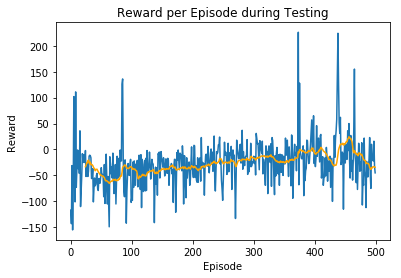

In [13]:
# test reward of each episode
plt.plot(episode_test_reward_list)
plt.title('Reward per Episode during Testing')
plt.xlabel('Episode')
plt.ylabel('Reward')

# plot moving average
delta_frame = pd.DataFrame(episode_test_reward_list)
rolling_mean = delta_frame.rolling(window=window_length).mean()
plt.plot(rolling_mean, label='Moving Average', color='orange')

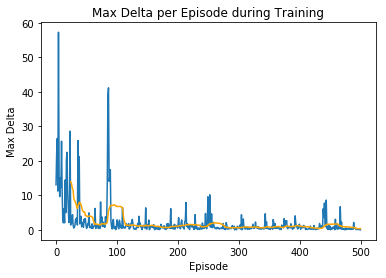

In [14]:
# max delta of each episode, where delta is the change in Q values
plt.plot(delta_list)
plt.title('Max Delta per Episode during Training')
plt.xlabel('Episode')
plt.ylabel('Max Delta')

# plot moving average
delta_frame = pd.DataFrame(delta_list)
rolling_mean = delta_frame.rolling(window=window_length).mean()
plt.plot(rolling_mean, label='Moving Average', color='orange')

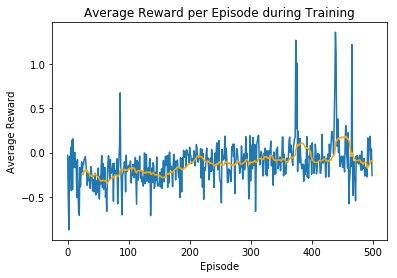

In [15]:
# average reward per episode
plt.plot(average_reward_list)
plt.title('Average Reward per Episode during Training')
plt.xlabel('Episode')
plt.ylabel('Average Reward')

# plot moving average
reward_frame = pd.DataFrame(average_reward_list)
rolling_mean = reward_frame.rolling(window=window_length).mean()
plt.plot(rolling_mean, label='Moving Average', color='orange')

Text(0, 0.5, 'Cumulative Reward')

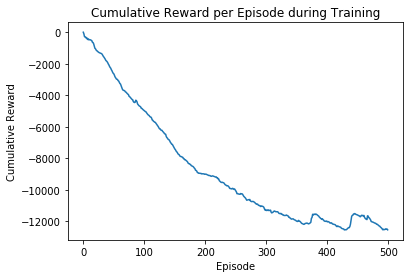

In [16]:
# cumulative reward per episode
plt.plot(cumulative_reward_list)
plt.title('Cumulative Reward per Episode during Training')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')

In [17]:
np.set_printoptions(precision=4)
Q_values

array([[  3.565 ,   2.4945,  -2.5464, -10.5555],
       [ -1.1166,   5.6893,   6.01  ,   5.0847],
       [  0.03  ,   0.8005,  -3.894 ,  -0.5963],
       [  6.955 ,   3.0101,   2.7134,   3.6794],
       [ -4.5187,   5.2418,  -0.3742,   7.5578],
       [ -8.4867,   4.2658,  -5.9721,  -2.3495],
       [  2.8887,   2.1583,  -1.5769,   2.6463],
       [ -6.5222,  -5.971 ,   1.2687,   2.3306],
       [  2.7249,   3.2232,  -3.2438,   2.6604],
       [  0.0512,   1.4565,   3.0159,   2.9931],
       [  1.5252,  -4.0389,  -2.2895,   4.3175],
       [  1.5933,  -2.0565,   1.7737,  -1.8376],
       [ -2.2932,  -4.4201,  -5.3363,   1.4662],
       [ -1.3343,  -2.6979,  -2.5004,  -2.5388],
       [  2.4794,  -4.6185, -10.4019,  -4.8782],
       [  1.0364,  -5.0625, -14.3408,  -4.9933],
       [ -1.6545,  -4.2596,  -6.1225,  -5.2732],
       [ -6.332 ,  -6.2575,  -7.7172,  -2.4595],
       [ -1.2234,  -9.8271,  -4.9763,  -4.8641],
       [ -0.3373,   1.4472,  -8.0717,  -1.1947],
       [ -5.8269,  -

## Visualize Final Policy

In [18]:
# PRINT POLICY TABLE ################################################################################
# import pandas library
import pandas as pd
# define column and index
columns=range(grid.size)
index = range(grid.size)
# define dataframe to represent policy table
policy_table = pd.DataFrame(index = index, columns=columns)

# iterate through policy to make a table that represents action number
# as action name (eg. left, right, up, down)
for state in range(len(policy)):
    
    # find the best action at each state
    best_action = np.argmax(policy[state])

    # get action name
    if best_action == 0:
        action_name = 'up'
    elif best_action == 1:
        action_name = 'right'
    elif best_action == 2:
        action_name = 'down'
    else:
        action_name = 'left'

    # calculate the row and column coordinate of the current state number
    row = int(state/grid.size)
    column = round((state/grid.size - int(state/grid.size))*grid.size)
            
    # assign action name
    policy_table.loc[row][column] = action_name

print("Policy Table: ")
print(policy_table)
print()

Policy Table: 
       0     1      2      3      4
0     up  down  right     up   left
1  right    up   left  right   down
2   left  down   left     up     up
3     up    up   left     up  right
4   left    up  right     up     up

